# 1.项目背景

在当今的商业环境中，用户转化率是衡量营销活动效果的关键指标。准确预测用户是否转化对于制定有效的营销策略和优化资源配置至关重要。通过数据分析和机器学习模型，分析影响用户转化的主要因素，可以帮助营销团队更好地理解客户行为，从而制定更有针对性的策略，提升整体转化率。本项目深入探讨了影响用户转化的关键因素，并成功建立了有效的预测模型。研究结果为优化营销策略提供了重要参考，有助于提高整体客户转化率。

# 2.数据说明

| 字段 | 说明 |  
| --- | --- |  
| CustomerID | 每个客户的唯一标识符。 |  
| Age | 客户的年龄。 |  
| Gender | 客户的性别（男性/女性）。 |  
| Income | 客户的年收入，以美元计。 |  
| CampaignChannel | 营销活动传递的渠道：电子邮件(Email)、社交媒体(Social Media)、搜索引擎优化(SEO)、付费点击(PPC)、推荐(Referral))。 |  
| CampaignType | 营销活动的类型：意识(Awareness)、考虑(Consideration)、转化(Conversion)、留存(Retention)。 |  
| AdSpend | 在营销活动上的花费，以美元计。 |  
| ClickThroughRate | 客户点击营销内容的比率。 |  
| ConversionRate | 点击转化为期望行为（如购买）的比率。 |  
| WebsiteVisits | 访问网站的总次数。 |  
| PagesPerVisit | 每次会话平均访问的页面数。 |  
| TimeOnSite | 每次访问平均在网站上花费的时间（分钟）。 |  
| SocialShares | 营销内容在社交媒体上被分享的次数。 |  
| EmailOpens | 营销电子邮件被打开的次数。 |  
| EmailClicks | 营销电子邮件中链接被点击的次数。 |  
| PreviousPurchases | 客户之前进行的购买次数。 |  
| LoyaltyPoints | 客户累积的忠诚度积分数。 |  
| AdvertisingPlatform | 广告平台（保密）。 |  
| AdvertisingTool | 广告工具（保密）。 |  
| Conversion | 目标变量：二元变量，表示客户是否转化（1）或未转化（0）。 |

# 3.Python库导入及数据读取

In [1]:
!pip install imblearn -i https://pypi.tuna.tsinghua.edu.cn/simple/

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve, auc

In [3]:
data = pd.read_csv('digital_marketing_campaign_dataset.csv')

# 4.数据预览

In [4]:
# 查看数据维度
data.shape

(8000, 20)

In [5]:
# 查看数据信息
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [6]:
# 查看各列缺失值
data.isna().sum()

CustomerID             0
Age                    0
Gender                 0
Income                 0
CampaignChannel        0
CampaignType           0
AdSpend                0
ClickThroughRate       0
ConversionRate         0
WebsiteVisits          0
PagesPerVisit          0
TimeOnSite             0
SocialShares           0
EmailOpens             0
EmailClicks            0
PreviousPurchases      0
LoyaltyPoints          0
AdvertisingPlatform    0
AdvertisingTool        0
Conversion             0
dtype: int64

In [7]:
# 查看重复值
data.duplicated().sum()

0

In [8]:
# 查看分类特征的唯一值
characteristic = ['Gender','CampaignChannel','CampaignType','AdvertisingPlatform','AdvertisingTool']
for i in characteristic:
    print(f'{i}:')
    print(data[i].unique())
    print('-'*50)

Gender:
['Female' 'Male']
--------------------------------------------------
CampaignChannel:
['Social Media' 'Email' 'PPC' 'Referral' 'SEO']
--------------------------------------------------
CampaignType:
['Awareness' 'Retention' 'Conversion' 'Consideration']
--------------------------------------------------
AdvertisingPlatform:
['IsConfid']
--------------------------------------------------
AdvertisingTool:
['ToolConfid']
--------------------------------------------------


In [10]:
# Mac绘图的字体
plt.rcParams['font.family'] = ['Arial Unicode MS']

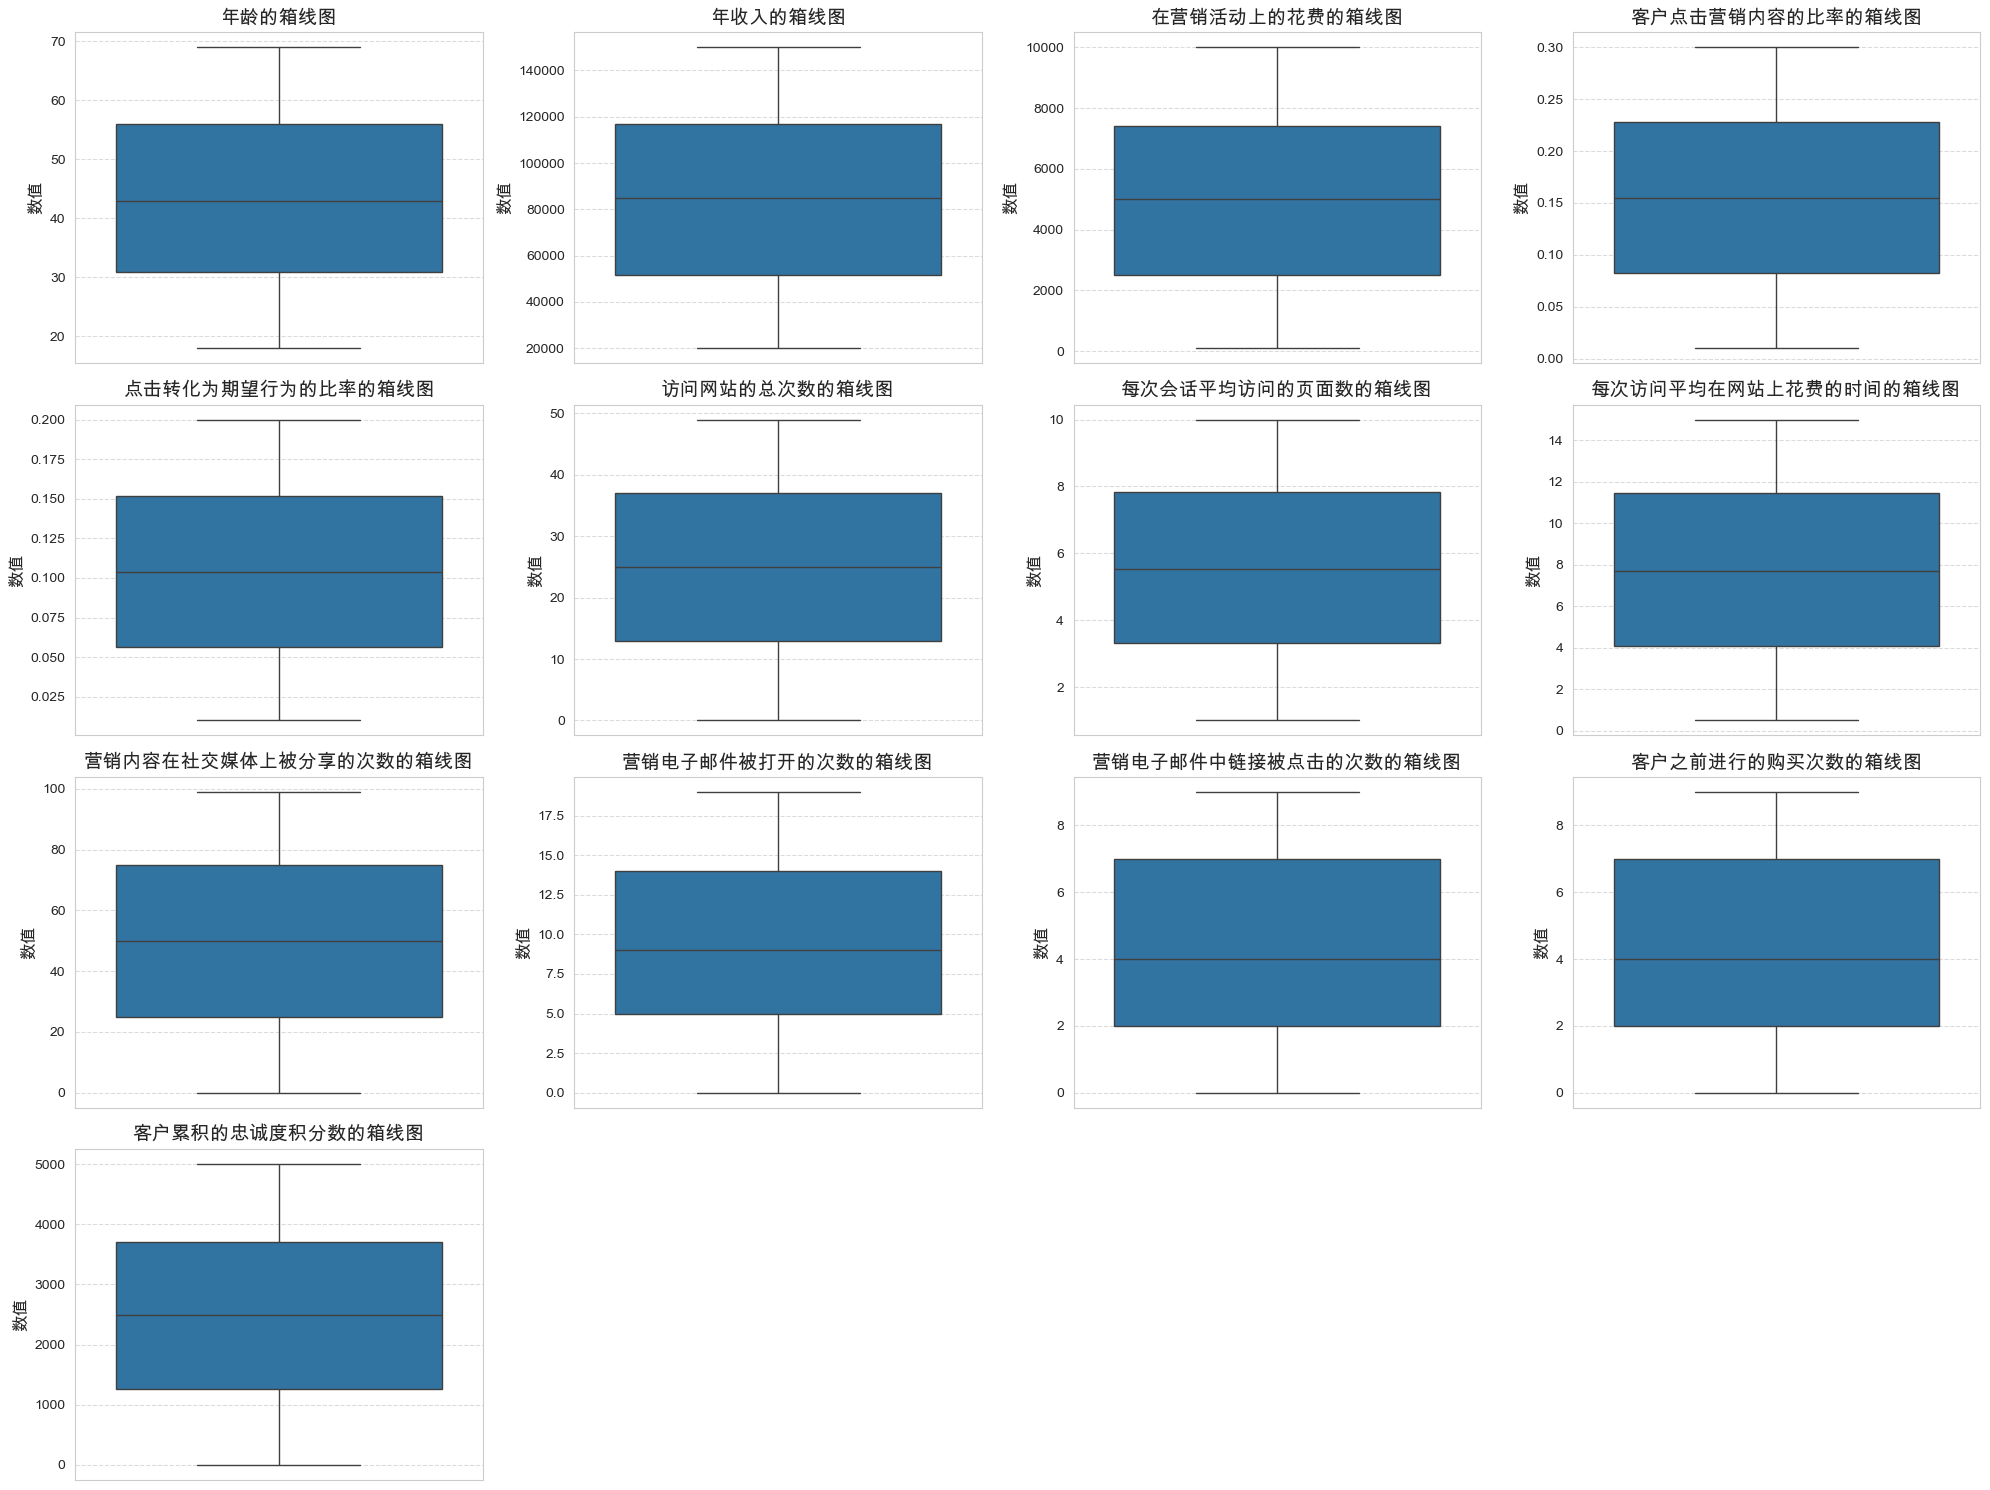

In [11]:
#绘制箱线图来观察是否存在异常值
# 定义特征及其中文名称映射
feature_map = {
    'Age': '年龄',
    'Income': '年收入',
    'AdSpend': '在营销活动上的花费',
    'ClickThroughRate': '客户点击营销内容的比率',
    'ConversionRate': '点击转化为期望行为的比率',
    'WebsiteVisits': '访问网站的总次数',
    'PagesPerVisit': '每次会话平均访问的页面数',
    'TimeOnSite': '每次访问平均在网站上花费的时间',
    'SocialShares':'营销内容在社交媒体上被分享的次数',
    'EmailOpens':'营销电子邮件被打开的次数',
    'EmailClicks':'营销电子邮件中链接被点击的次数',
    'PreviousPurchases':'客户之前进行的购买次数',
    'LoyaltyPoints':'客户累积的忠诚度积分数',
}
plt.figure(figsize=(20, 15))

for i, (col, col_name) in enumerate(feature_map.items(), 1):
    plt.subplot(4, 4, i)
    sns.boxplot(y=data[col])
    plt.title(f'{col_name}的箱线图', fontsize=14)
    plt.ylabel('数值', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**数据比较干净，但是AdvertisingTool、AdvertisingPlatform这两列特征为保密，对后续的分析没有帮助，这里直接删除。**

In [12]:
# 删除AdvertisingTool、AdvertisingPlatform列
data.drop(['AdvertisingTool','AdvertisingPlatform'],axis=1,inplace=True)

In [13]:
data.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,1
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,1
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,1
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,1
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,1


# 5.描述性统计

In [14]:
data.describe(include='all')

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,Conversion
count,8000.00000,8000.000000,8000,8000.000000,8000,8000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
unique,NaN,NaN,2,NaN,5,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,Female,NaN,Referral,Conversion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,4839,NaN,1719,2077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,11999.50000,43.625500,NaN,84664.196750,NaN,NaN,5000.944830,0.154829,0.104389,24.751625,5.549299,7.727718,49.799750,9.476875,4.467375,4.485500,2490.268500,0.876500
std,2309.54541,14.902785,NaN,37580.387945,NaN,NaN,2838.038153,0.084007,0.054878,14.312269,2.607358,4.228218,28.901165,5.711111,2.856564,2.888093,1429.527162,0.329031
min,8000.00000,18.000000,NaN,20014.000000,NaN,NaN,100.054813,0.010005,0.010018,0.000000,1.000428,0.501669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9999.75000,31.000000,NaN,51744.500000,NaN,NaN,2523.221165,0.082635,0.056410,13.000000,3.302479,4.068340,25.000000,5.000000,2.000000,2.000000,1254.750000,1.000000
50%,11999.50000,43.000000,NaN,84926.500000,NaN,NaN,5013.440044,0.154505,0.104046,25.000000,5.534257,7.682956,50.000000,9.000000,4.000000,4.000000,2497.000000,1.000000
75%,13999.25000,56.000000,NaN,116815.750000,NaN,NaN,7407.989369,0.228207,0.152077,37.000000,7.835756,11.481468,75.000000,14.000000,7.000000,7.000000,3702.250000,1.000000


* **CustomerID**: 每个客户的唯一标识符。  
* **Age**: 平均年龄为43.63岁，最小年龄为18岁，最大年龄为69岁。  
* **Income**: 平均年收入为84,664.20美元。  
* **AdSpend**: 平均广告花费为5,000.94美元。  
* **ClickThroughRate**: 平均点击率为0.1548。  
* **ConversionRate**: 平均转化率为0.1044。  
* **WebsiteVisits**: 平均网站访问次数为24.75次。  
* **PagesPerVisit**: 平均每次访问的页面数为5.55页。  
* **TimeOnSite**: 平均每次访问在网站上花费的时间为7.73分钟。  
* **SocialShares**: 平均社交分享次数为49.80次。  
* **EmailOpens**: 平均电子邮件打开次数为9.48次。  
* **EmailClicks**: 平均电子邮件点击次数为4.47次。  
* **PreviousPurchases**: 平均之前购买次数为4.49次。  
* **LoyaltyPoints**: 平均忠诚度积分为2,490.27分。  
* **Gender**: 男女比例分别为4839名女性和3161名男性。  
* **CampaignChannel**: 五种营销渠道中，以推荐(Referral)渠道使用最多。  
* **CampaignType**: 四种营销类型中，以转化(Conversion)类型最多。  
* **Conversion**: 转化率为87.65%。

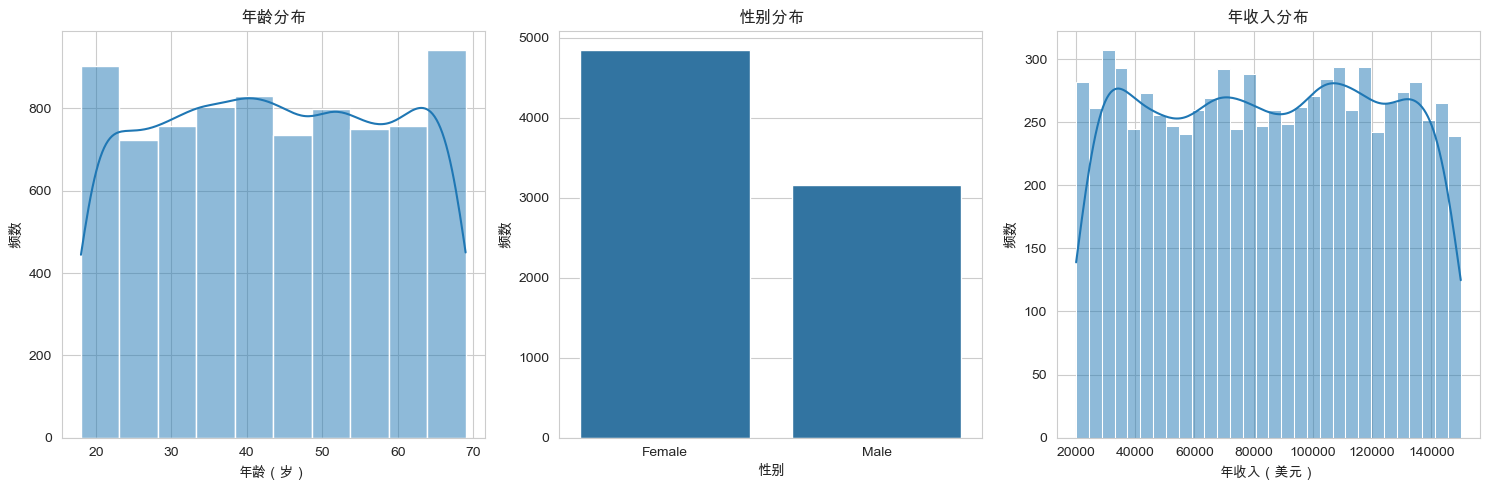

In [15]:
# 用户基本信息
plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
sns.histplot(data['Age'], kde=True, bins=10)
plt.title('年龄分布')
plt.xlabel('年龄（岁）')
plt.ylabel('频数')

plt.subplot(1, 3, 2)
sns.countplot(x = data['Gender'])
plt.title('性别分布')
plt.xlabel('性别')
plt.ylabel('频数')

plt.subplot(1, 3, 3)
sns.histplot(data['Income'], kde=True, bins=30)
plt.title('年收入分布')
plt.xlabel('年收入（美元）')
plt.ylabel('频数')

plt.tight_layout()
plt.show()

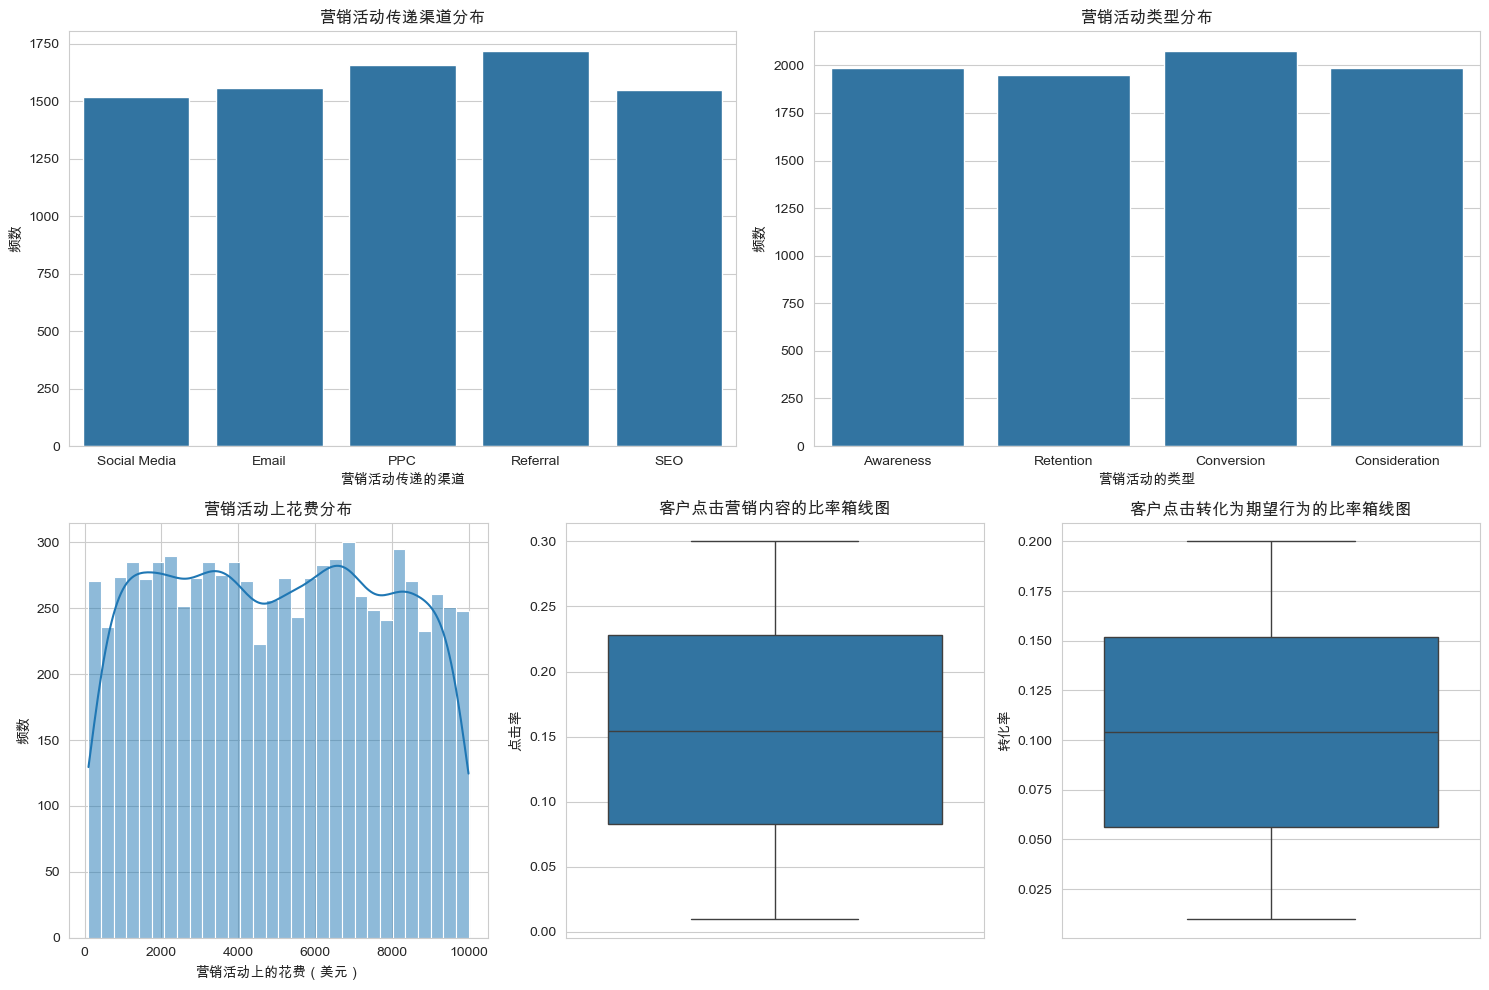

In [18]:
# 营销情况
plt.figure(figsize=(15,10))
plt.subplot(2, 6, (1,3))
sns.countplot(x = data['CampaignChannel'])
plt.title('营销活动传递渠道分布')
plt.xlabel('营销活动传递的渠道')
plt.ylabel('频数')

plt.subplot(2, 6, (4,6))
sns.countplot(x = data['CampaignType'])
plt.title('营销活动类型分布')
plt.xlabel('营销活动的类型')
plt.ylabel('频数')

plt.subplot(2, 6, (7,8))
sns.histplot(data['AdSpend'], kde=True, bins=30)
plt.title('营销活动上花费分布')
plt.xlabel('营销活动上的花费（美元）')
plt.ylabel('频数')

plt.subplot(2, 6, (9,10))
sns.boxplot(y=data['ClickThroughRate'])
plt.title('客户点击营销内容的比率箱线图')
plt.ylabel('点击率')

plt.subplot(2, 6, (11,12))
sns.boxplot(y=data['ConversionRate'])
plt.title('客户点击转化为期望行为的比率箱线图')
plt.ylabel('转化率')

plt.tight_layout()
plt.show()

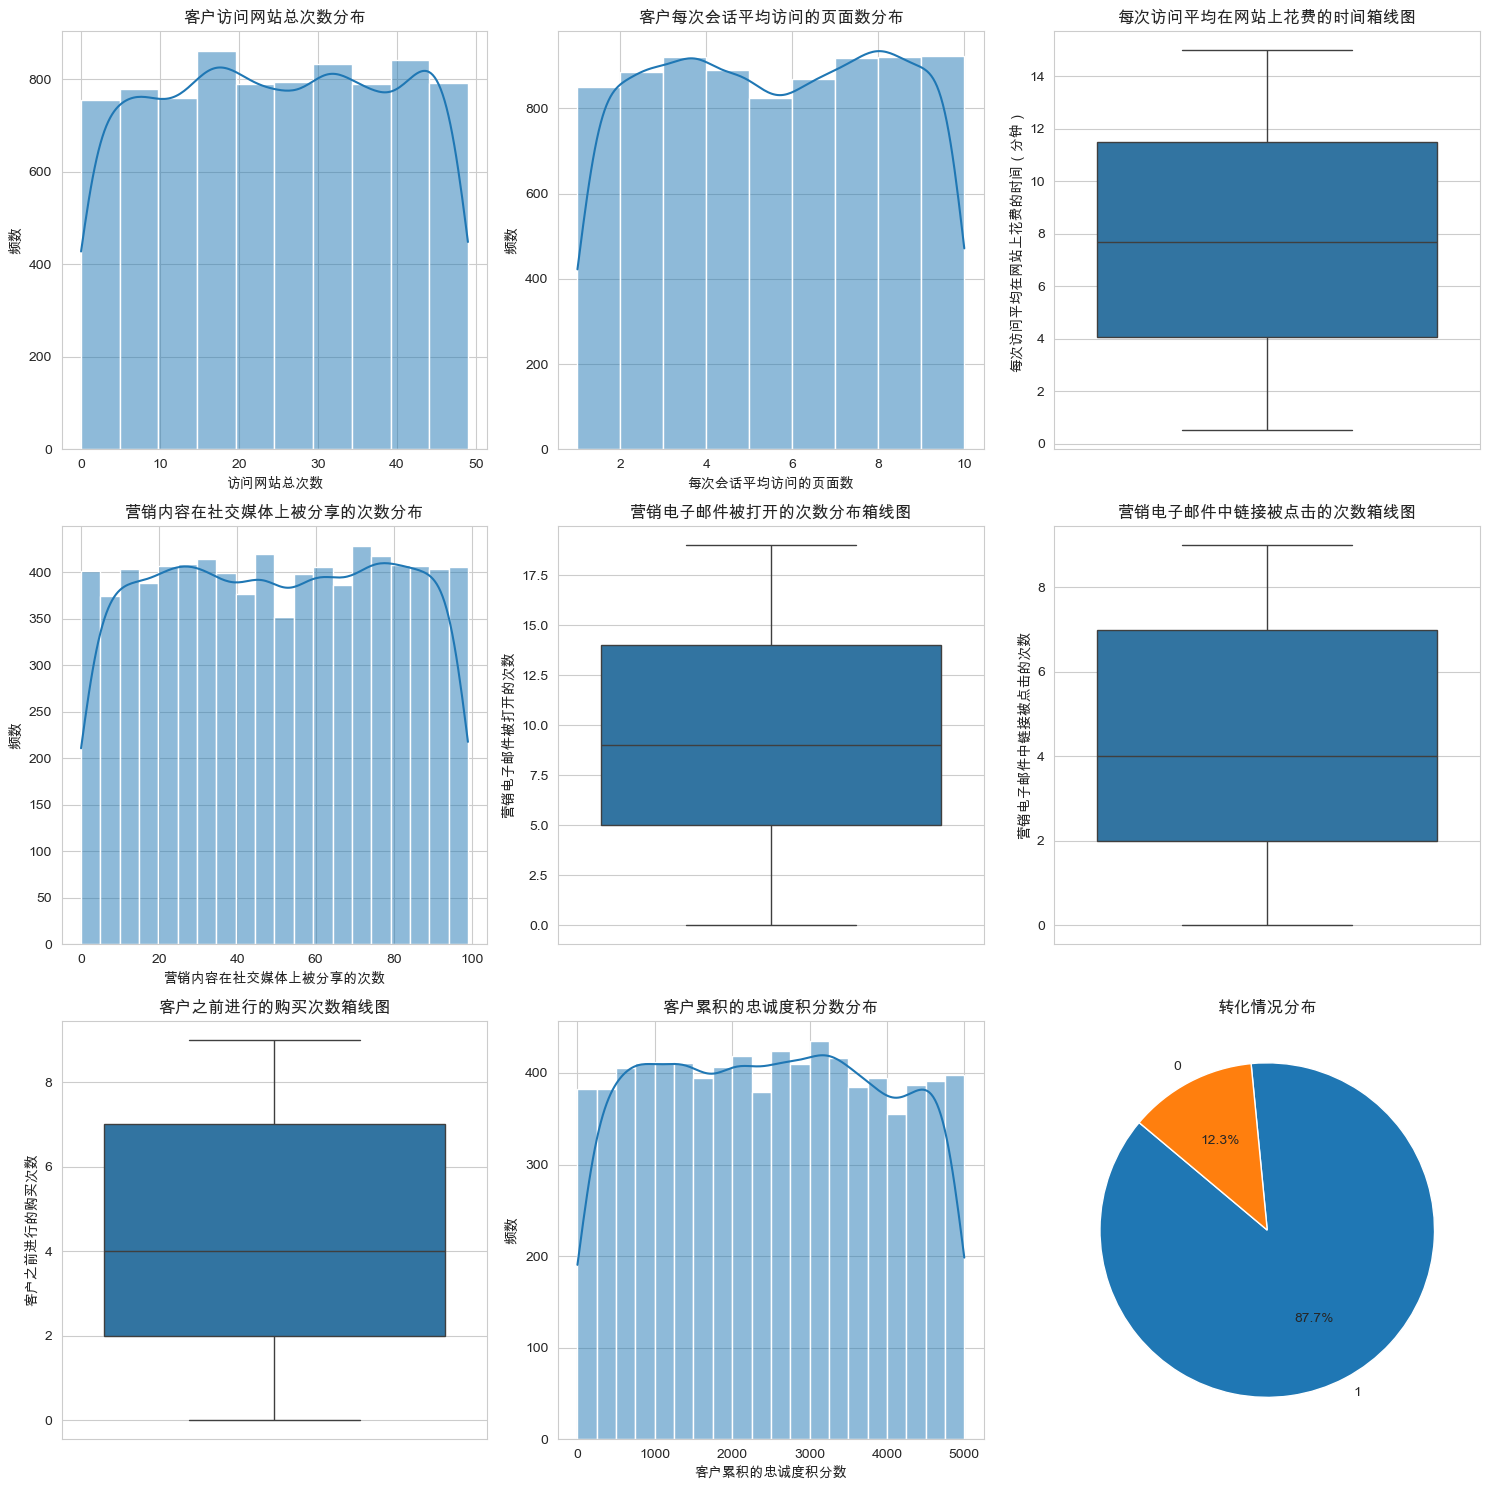

In [19]:
# 客户参与情况
plt.figure(figsize=(15,15))

plt.subplot(3, 3, 1)
sns.histplot(data['WebsiteVisits'], kde=True, bins=10)
plt.title('客户访问网站总次数分布')
plt.xlabel('访问网站总次数')
plt.ylabel('频数')

plt.subplot(3, 3, 2)
sns.histplot(data['PagesPerVisit'], kde=True, bins=9)
plt.title('客户每次会话平均访问的页面数分布')
plt.xlabel('每次会话平均访问的页面数')
plt.ylabel('频数')

plt.subplot(3, 3, 3)
sns.boxplot(y=data['TimeOnSite'])
plt.title('每次访问平均在网站上花费的时间箱线图')
plt.ylabel('每次访问平均在网站上花费的时间（分钟）')

plt.subplot(3, 3, 4)
sns.histplot(data['SocialShares'], kde=True, bins=20)
plt.title('营销内容在社交媒体上被分享的次数分布')
plt.xlabel('营销内容在社交媒体上被分享的次数')
plt.ylabel('频数')

plt.subplot(3, 3, 5)
sns.boxplot(y=data['EmailOpens'])
plt.title('营销电子邮件被打开的次数分布箱线图')
plt.ylabel('营销电子邮件被打开的次数')

plt.subplot(3, 3, 6)
sns.boxplot(y=data['EmailClicks'])
plt.title('营销电子邮件中链接被点击的次数箱线图')
plt.ylabel('营销电子邮件中链接被点击的次数')

plt.subplot(3, 3, 7)
sns.boxplot(y=data['PreviousPurchases'])
plt.title('客户之前进行的购买次数箱线图')
plt.ylabel('客户之前进行的购买次数')

plt.subplot(3, 3, 8)
sns.histplot(data['LoyaltyPoints'], kde=True, bins=20)
plt.title('客户累积的忠诚度积分数分布')
plt.xlabel('客户累积的忠诚度积分数')
plt.ylabel('频数')

plt.subplot(3, 3, 9)
conversion_counts = data['Conversion'].value_counts()
plt.pie(conversion_counts, labels=conversion_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('转化情况分布')

plt.tight_layout()
plt.show()

# 6.用户转化影响因素分析

## 6.1可视化分析

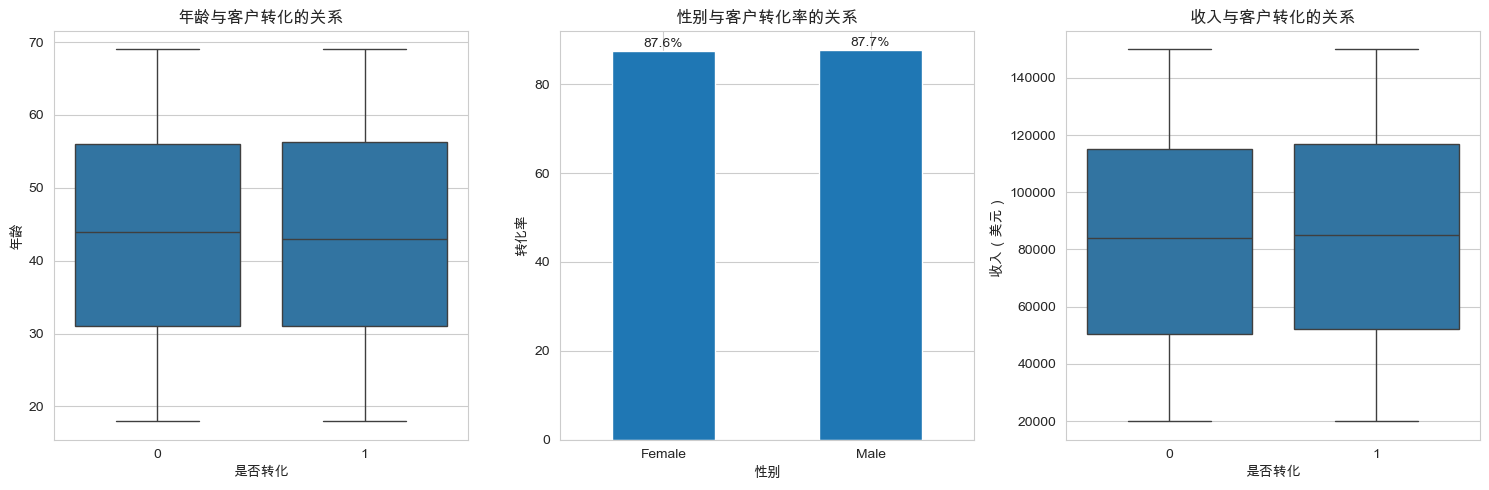

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
sns.boxplot(x=data['Conversion'],y=data['Age'])
plt.title('年龄与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('年龄')

gender_and_conversion = pd.crosstab(data['Gender'], data['Conversion'])
gender_and_conversion_percent = gender_and_conversion.div(gender_and_conversion.sum(axis=1), axis=0) * 100
ax2 = plt.subplot(1,3,2)
gender_and_conversion_percent[1].plot(kind='bar',ax=ax2)
plt.title('性别与客户转化率的关系')
plt.xlabel('性别')
plt.ylabel('转化率')
plt.xticks(rotation=0)
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.subplot(1,3,3)
sns.boxplot(x=data['Conversion'],y=data['Income'])
plt.title('收入与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('收入（美元）')

plt.tight_layout()
plt.show()

从这些图表可以看出，年龄、性别和收入对客户是否转化没有显著的影响。

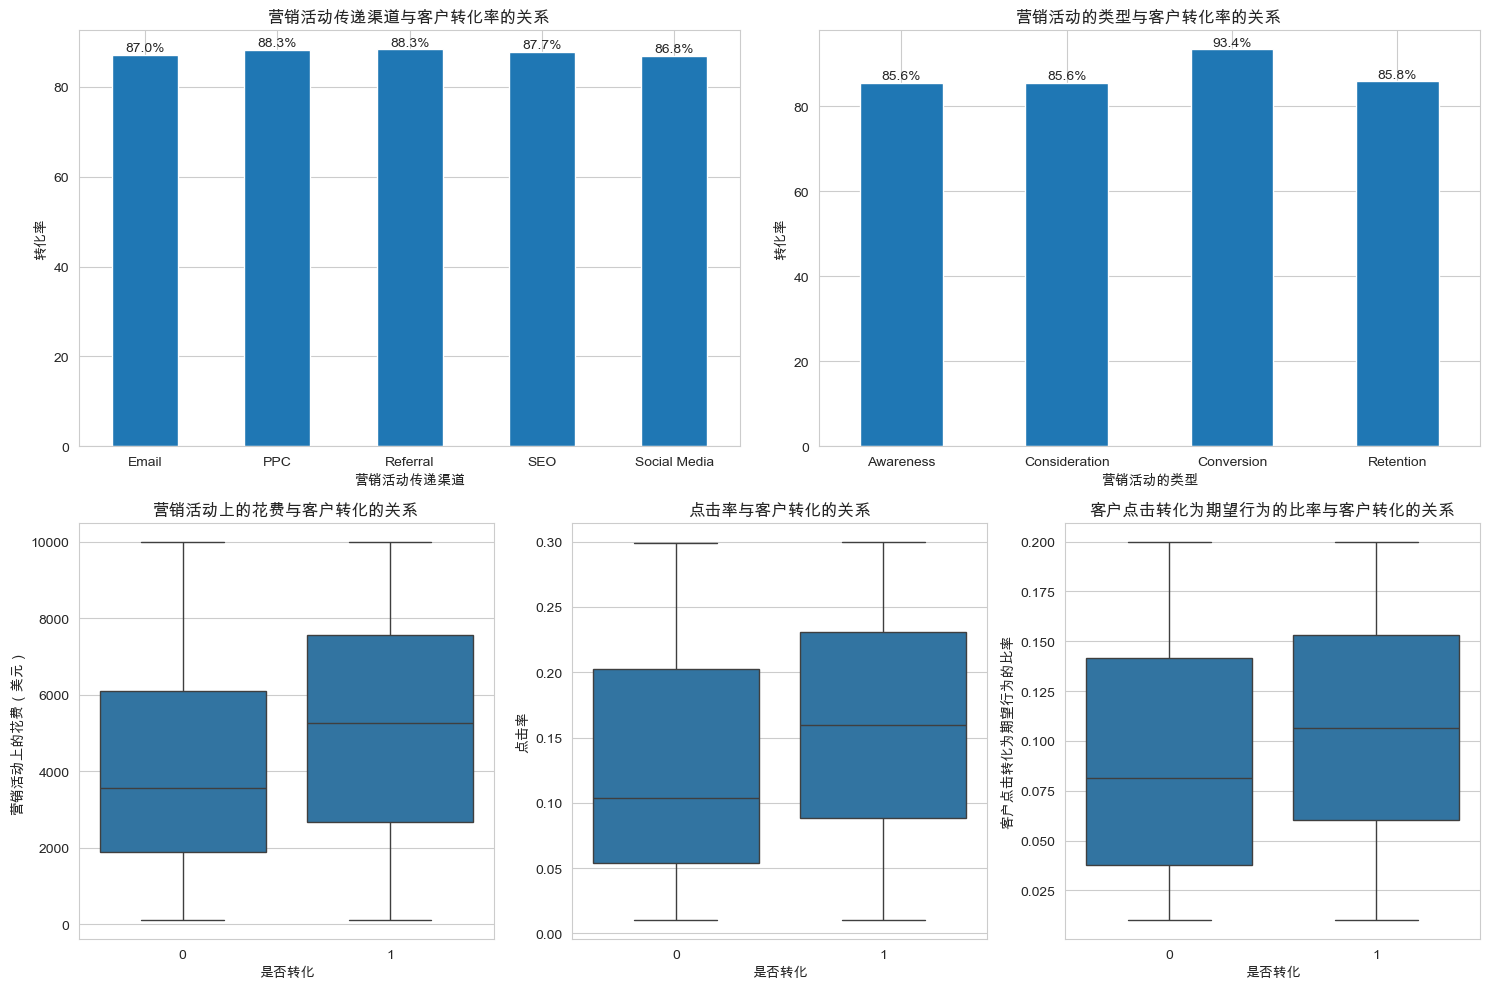

In [21]:
plt.figure(figsize=(15,10))
ax1 = plt.subplot(2, 6, (1,3))
campaign_channel_and_conversion = pd.crosstab(data['CampaignChannel'], data['Conversion'])
campaign_channel_and_conversion_percent = campaign_channel_and_conversion.div(campaign_channel_and_conversion.sum(axis=1), axis=0) * 100
campaign_channel_and_conversion_percent[1].plot(kind='bar',ax=ax1)
plt.title('营销活动传递渠道与客户转化率的关系')
plt.xlabel('营销活动传递渠道')
plt.ylabel('转化率')
plt.xticks(rotation=0)
for p in ax1.patches:
    ax1.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

ax2 = plt.subplot(2, 6, (4,6))
campaign_type_and_conversion = pd.crosstab(data['CampaignType'], data['Conversion'])
campaign_type_and_conversion_percent = campaign_type_and_conversion.div(campaign_type_and_conversion.sum(axis=1), axis=0) * 100
campaign_type_and_conversion_percent[1].plot(kind='bar',ax=ax2)
plt.title('营销活动的类型与客户转化率的关系')
plt.xlabel('营销活动的类型')
plt.ylabel('转化率')
plt.xticks(rotation=0)
for p in ax2.patches:
    ax2.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.subplot(2, 6, (7,8))
sns.boxplot(x=data['Conversion'],y=data['AdSpend'])
plt.title('营销活动上的花费与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('营销活动上的花费（美元）')

plt.subplot(2, 6, (9,10))
sns.boxplot(x=data['Conversion'],y=data['ClickThroughRate'])
plt.title('点击率与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('点击率')


plt.subplot(2, 6, (11,12))
sns.boxplot(x=data['Conversion'],y=data['ConversionRate'])
plt.title('客户点击转化为期望行为的比率与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户点击转化为期望行为的比率')

plt.tight_layout()
plt.show()

从这些图表中可以看出：  
* 营销活动传递渠道的转化率都比较接近。  
* 以转化(Conversion)为目标的转化率最高，为93.4%。  
* 广告花费、点击率、点击转化率在转化和未转化客户间有显著差异。

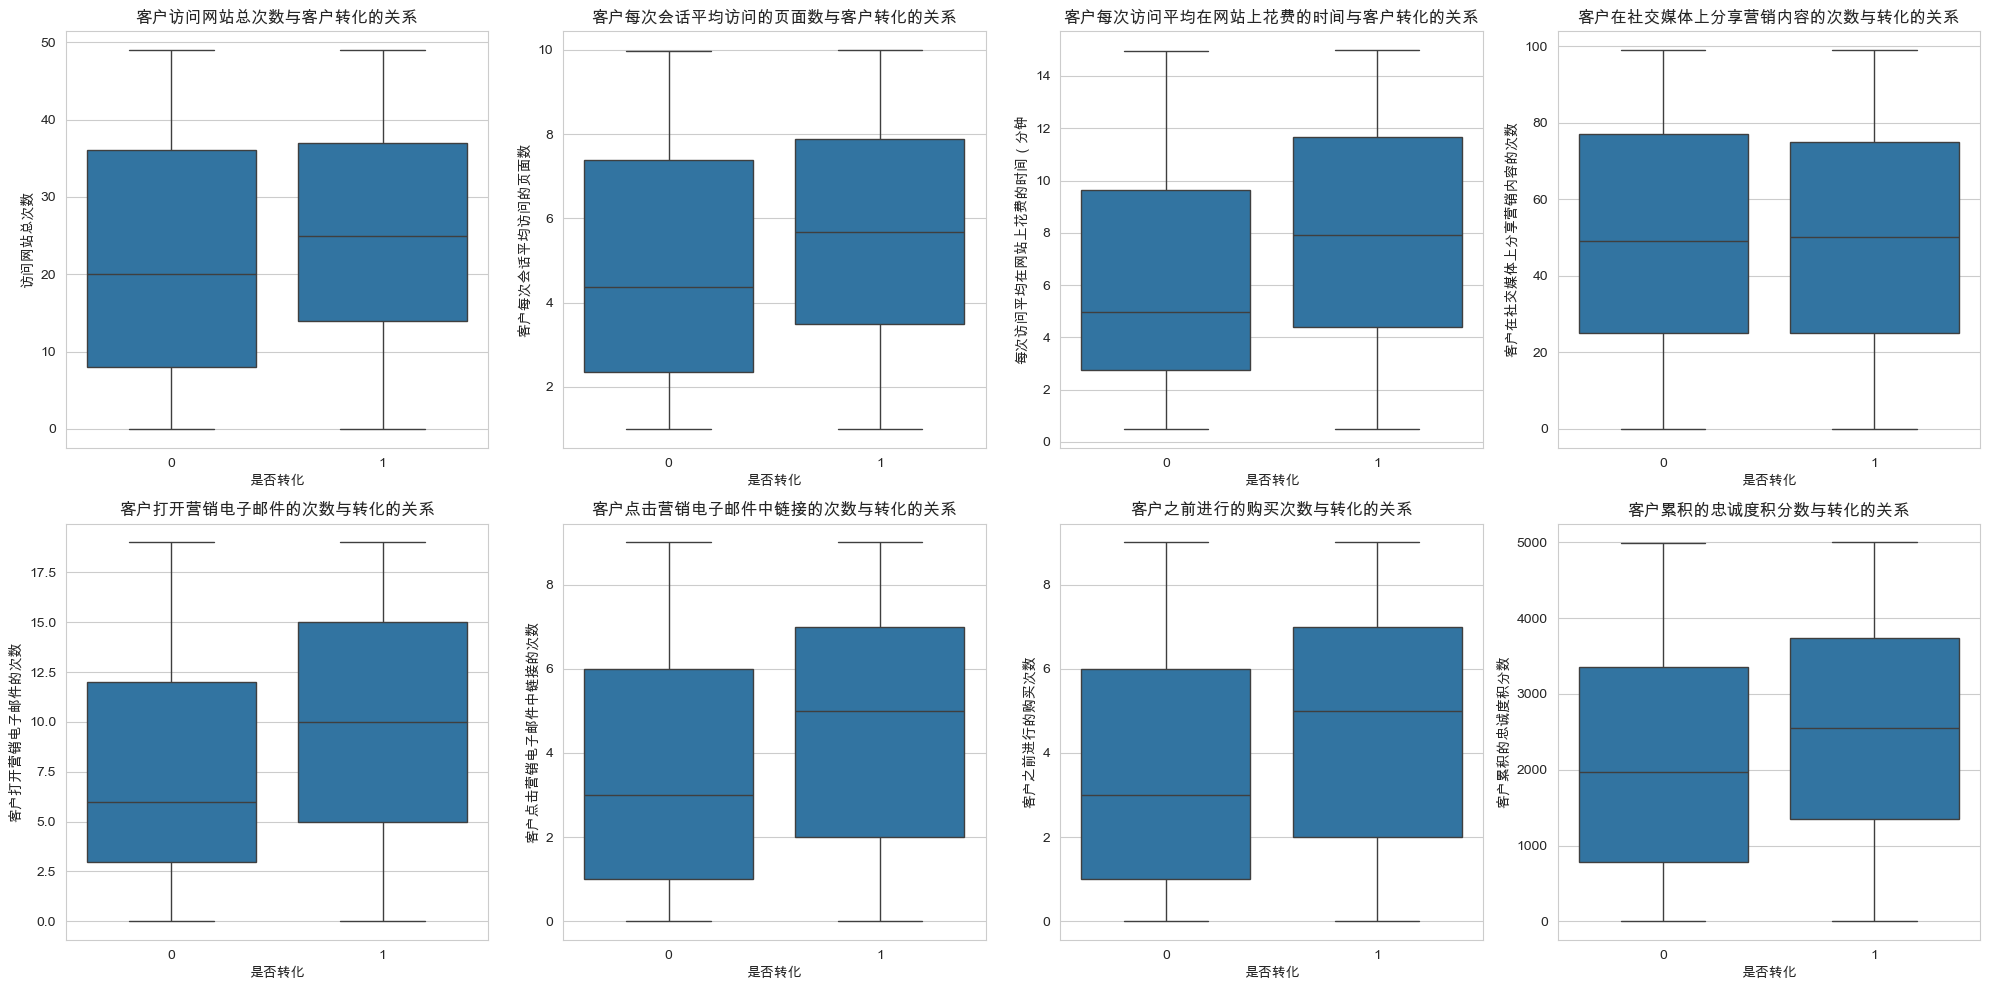

In [22]:
plt.figure(figsize=(20,10))

plt.subplot(2, 4, 1)
sns.boxplot(x=data['Conversion'],y=data['WebsiteVisits'])
plt.title('客户访问网站总次数与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('访问网站总次数')

plt.subplot(2, 4, 2)
sns.boxplot(x=data['Conversion'],y=data['PagesPerVisit'])
plt.title('客户每次会话平均访问的页面数与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户每次会话平均访问的页面数')

plt.subplot(2, 4, 3)
sns.boxplot(x=data['Conversion'],y=data['TimeOnSite'])
plt.title('客户每次访问平均在网站上花费的时间与客户转化的关系')
plt.xlabel('是否转化')
plt.ylabel('每次访问平均在网站上花费的时间（分钟')

plt.subplot(2, 4, 4)
sns.boxplot(x=data['Conversion'],y=data['SocialShares'])
plt.title('客户在社交媒体上分享营销内容的次数与转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户在社交媒体上分享营销内容的次数')

plt.subplot(2, 4, 5)
sns.boxplot(x=data['Conversion'],y=data['EmailOpens'])
plt.title('客户打开营销电子邮件的次数与转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户打开营销电子邮件的次数')

plt.subplot(2, 4, 6)
sns.boxplot(x=data['Conversion'],y=data['EmailClicks'])
plt.title('客户点击营销电子邮件中链接的次数与转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户点击营销电子邮件中链接的次数')

plt.subplot(2, 4, 7)
sns.boxplot(x=data['Conversion'],y=data['PreviousPurchases'])
plt.title('客户之前进行的购买次数与转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户之前进行的购买次数')

plt.subplot(2, 4, 8)
sns.boxplot(x=data['Conversion'],y=data['LoyaltyPoints'])
plt.title('客户累积的忠诚度积分数与转化的关系')
plt.xlabel('是否转化')
plt.ylabel('客户累积的忠诚度积分数')

plt.tight_layout()
plt.show()

通过这些图可以看到：客户转化情况与访问网站总次数、每次会话平均访问的页面数、每次访问平均在网站上花费的时间、打开营销电子邮件的次数、点击营销电子邮件中链接的次数、之前进行的购买次数、累积的忠诚度积分有关，与在社交媒体上分享营销内容的次数无关。

## 6.2斯皮尔曼相关性分析

In [29]:
def plot_spearmanr(data,features,title,wide,height):
    # 计算斯皮尔曼相关性矩阵和p值矩阵
    spearman_corr_matrix = data[features].corr(method='spearman')
    pvals = data[features].corr(method=lambda x, y: spearmanr(x, y)[1]) - np.eye(len(data[features].columns))
    
    # 转换 p 值为星号
    def convert_pvalue_to_asterisks(pvalue):
        if pvalue <= 0.001:
            return "***"
        elif pvalue <= 0.01:
            return "**"
        elif pvalue <= 0.05:
            return "*"
        return ""

    # 应用转换函数
    pval_star = pvals.applymap(lambda x: convert_pvalue_to_asterisks(x))

    # 转换成 numpy 类型
    corr_star_annot = pval_star.to_numpy()

    # 定制 labels
    corr_labels = spearman_corr_matrix.to_numpy()
    p_labels = corr_star_annot
    shape = corr_labels.shape

    # 合并 labels
    labels = (np.asarray(["{0:.2f}\n{1}".format(data, p) for data, p in zip(corr_labels.flatten(), p_labels.flatten())])).reshape(shape)

    # 绘制热力图
    fig, ax = plt.subplots(figsize=(height, wide), dpi=100, facecolor="w")
    sns.heatmap(spearman_corr_matrix, annot=labels, fmt='', cmap='coolwarm',
                vmin=-1, vmax=1, annot_kws={"size":10, "fontweight":"bold"},
                linecolor="k", linewidths=.2, cbar_kws={"aspect":13}, ax=ax)

    ax.tick_params(bottom=False, labelbottom=True, labeltop=False,
                left=False, pad=1, labelsize=12)
    ax.yaxis.set_tick_params(labelrotation=0)

    # 自定义 colorbar 标签格式
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(direction="in", width=.5, labelsize=10)
    cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    cbar.set_ticklabels(["-1.00", "-0.50", "0.00", "0.50", "1.00"])
    cbar.outline.set_visible(True)
    cbar.outline.set_linewidth(.5)

    plt.title(title)
    plt.show()

/var/folders/9z/k_ttzjsx40jc5zvrdq8wty200000gn/T/ipykernel_7044/885728009.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pval_star = pvals.applymap(lambda x: convert_pvalue_to_asterisks(x))


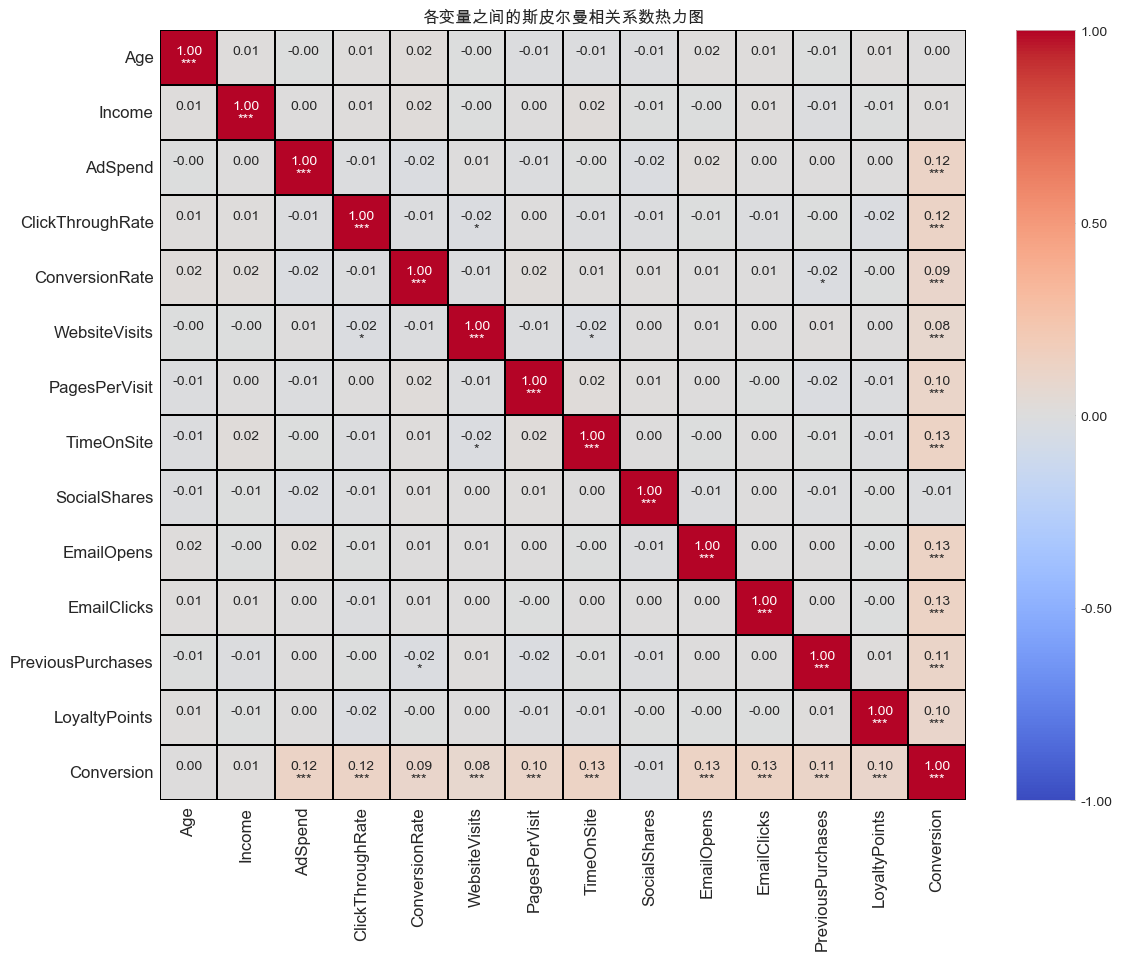

In [30]:
features = data.drop(['CustomerID','Gender','CampaignChannel','CampaignType'],axis=1).columns.tolist()
plot_spearmanr(data,features,'各变量之间的斯皮尔曼相关系数热力图',10,13)

通过斯皮尔曼相关性分析可以发现：客户转化情况与广告花费、点击率、点击转化率、访问网站总次数、每次会话平均访问的页面数、每次访问平均在网站上花费的时间、打开营销电子邮件的次数、点击营销电子邮件中链接的次数、之前进行的购买次数、累积的忠诚度积分有显著的相关关系，虽然大部分是弱正相关，但是与之前可视化分析得到的结论一致。

## 6.3卡方检验

In [31]:
# 卡方检验
def chi_square_test(var1, var2):
    contingency_table = pd.crosstab(data[var1], data[var2])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    return chi2, p

chi_square_results = {}
cat_features = ['Gender', 'CampaignChannel', 'CampaignType']
chi_square_results = {feature: chi_square_test(feature, 'Conversion') for feature in cat_features}

chi_square_df = pd.DataFrame.from_dict(chi_square_results,orient='index',columns=['Chi-Square','P-Value'])
chi_square_df

,Chi-Square,P-Value
Gender,0.003771,9.510312e-01
CampaignChannel,2.784854,5.944500e-01
CampaignType,84.454396,3.398335e-18


通过卡方检验发现：优化营销活动类型可能是提高客户转化率的重要因素，而性别和营销活动传递渠道对转化率的影响不显著，也是与之前观察的结论一致。

# 7.使用随机森林预测转化率

## 7.1数据预处理

In [32]:
new_data = data.drop(['CustomerID','Age','Gender','Income','CampaignChannel','SocialShares'],axis=1)
label_encoder = LabelEncoder()
new_data['CampaignType'] = label_encoder.fit_transform(new_data['CampaignType'])
x = new_data.drop(['Conversion'],axis=1)
y = new_data['Conversion']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=15) #37分
# 实例化随机过采样器
oversampler = RandomOverSampler()
# 在训练集上进行随机过采样
x_train, y_train = oversampler.fit_resample(x_train, y_train)

## 7.2建立模型

In [33]:
rf_clf = RandomForestClassifier(random_state=15)
rf_clf.fit(x_train, y_train)

RandomForestClassifier(random_state=15)

In [34]:
y_pred_rf = rf_clf.predict(x_test)
class_report_rf = classification_report(y_test, y_pred_rf)
print(class_report_rf)

              precision    recall  f1-score   support

           0       0.81      0.33      0.46       291
           1       0.91      0.99      0.95      2109

    accuracy                           0.91      2400
   macro avg       0.86      0.66      0.71      2400
weighted avg       0.90      0.91      0.89      2400



从结果分析，模型在类1（转换）上表现较好，召回率（0.99）和 F1-score（0.95）都很高。
模型在类0（未转化）上表现一般，召回率只有0.33，说明模型难以识别类 0 的样本，可能是因为类别不平衡导致的。
尽管总体准确率为 0.91，但由于类 1 样本占多数，模型可能更偏向于预测类 1。因此，模型在类 0 上的低召回率可能影响了少数类的预测表现。

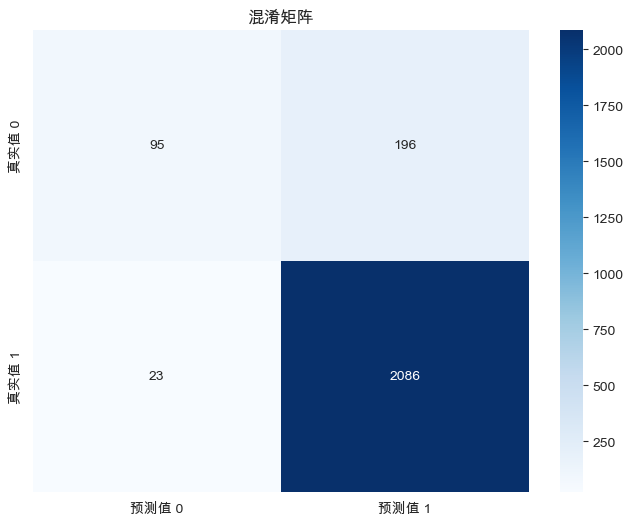

In [35]:
cm = confusion_matrix(y_test,y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['预测值 0', '预测值 1'], 
            yticklabels=['真实值 0', '真实值 1'])
plt.title('混淆矩阵')
plt.show()

从混淆矩阵的结果来看，模型在 类 1 上的表现较好，正确分类了 2086 个样本，仅错分了 23 个样本。
模型在 类 0 上的表现较差，仅正确分类了 95 个样本，而错分了 196 个样本。
这种不平衡表现可能同样是因为数据集中类1的样本较多导致的。

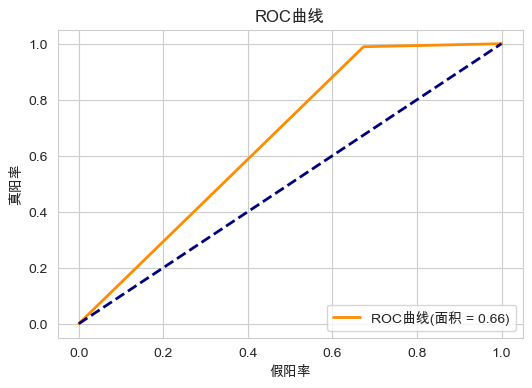

In [37]:
#绘制ROC曲线
fpr, tpr, _ = roc_curve(y_test, y_pred_rf)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC曲线(面积 = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('ROC曲线')
plt.legend(loc="lower right")
plt.show()

ROC曲线和AUC值可以用来评估分类模型的整体性能，根据结果，AUC 值为 0.66，说明模型的区分能力一般，对类 0 和类 1 的区分效果不佳。

因此，我们考虑在下一节使用 XGBoost 算法建立模型，对转化率进行预测。

## 7.3重要度分析

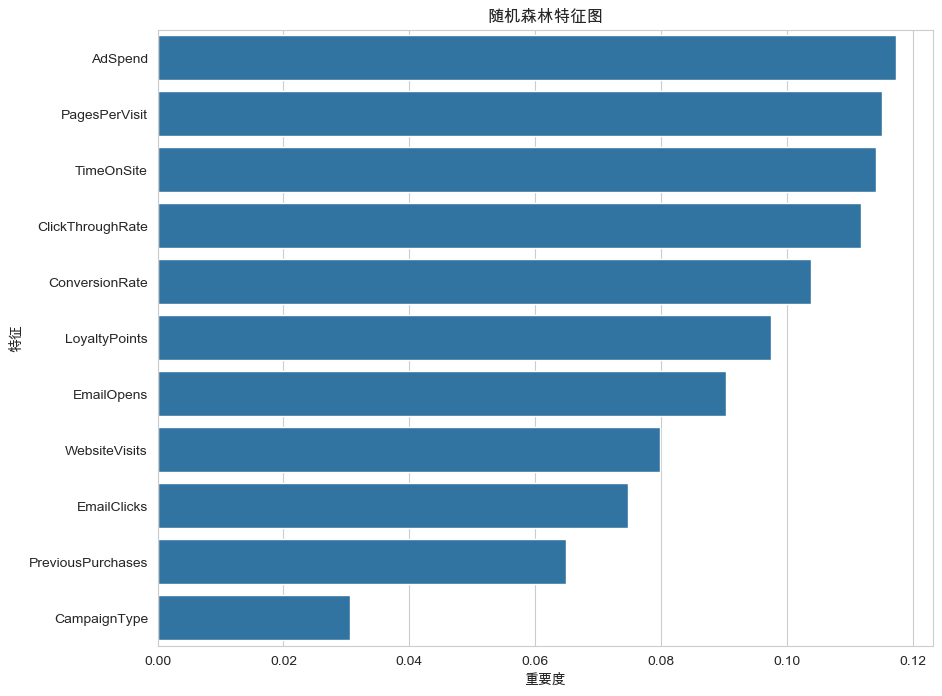

In [38]:
feature_importances = rf_clf.feature_importances_
features_rf = pd.DataFrame({'特征': x_train.columns, '重要度': feature_importances})
features_rf.sort_values(by='重要度', ascending=False, inplace=True)
plt.figure(figsize=(10, 8))
sns.barplot(x='重要度', y='特征', data=features_rf)
plt.xlabel('重要度')
plt.ylabel('特征')
plt.title('随机森林特征图')
plt.show()

从特征重要性图中可以看出，广告花费、每次访问页面数、网站停留时间、点击率、点击转换率和忠诚度积分是影响用户转化的最重要因素。营销策略应着重优化这些方面，以提高用户的转化率。

# 8.总结

本项目通过可视化分析对数据进行初步探索，再通过斯皮尔曼相关性检验和卡方检验探究用户转化的影响因素，最后建立了随机森林模型，去预测某个用户的转化情况，并且研究了影响模型的重要特征，结论如下：  
1. 通过绘制转化用户和未转化用户之间对比图，发现：年龄、性别和收入、营销活动传递渠道、在社交媒体上分享营销内容的次数对用户是否转化没有显著的影响，营销活动的类型、广告花费、点击率、点击转化率、访问网站总次数、每次会话平均访问的页面数、每次访问平均在网站上花费的时间、打开营销电子邮件的次数、点击营销电子邮件中链接的次数、之前进行的购买次数、累积的忠诚度积分对用户是否转化有显著的影响。  
2. 通过斯皮尔曼相关性分析发现：用户转化情况与广告花费、点击率、点击转化率、访问网站总次数、每次会话平均访问的页面数、每次访问平均在网站上花费的时间、打开营销电子邮件的次数、点击营销电子邮件中链接的次数、之前进行的购买次数、累积的忠诚度积分有显著的相关关系，虽然大部分是弱正相关，但是与之前可视化分析得到的结论一致。  
3. 通过卡方检验发现：优化营销活动类型可能是提高客户转化率的重要因素，而性别和营销活动传递渠道对转化率的影响不显著，也是与之前观察的结论一致。  
4. 随机森林模型的预测效果比较好，无论是针对转化用户还是未转化的用户，准确率都很高，可以通过该模型去识别一个用户是否转化。  
5. 从特征重要性图中可以看出，广告花费、每次访问页面数、网站停留时间、点击率、点击转换率和忠诚度积分是影响用户转化的最重要因素。营销策略应着重优化这些方面，以提高用户的转化率。